In [63]:
import math
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from tokenizers import (
    decoders,
    models,
    trainers,
    Tokenizer,
)

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

DEVICE = torch.device('mps') # 'mps' for ARM macbooks, 'cuda' for colab, 'cpu' otherwise

## Data

In [72]:
class CharacterTokenizer:
    """Character level tokenizer that enumerates unique characters in a training text"""
    def __init__(self, encoding_dict: dict[str, int]=None):
        if encoding_dict is None:
            self.encoding_dict = dict()
        else:
            self.encoding_dict = encoding_dict

    def __repr__(self):
        return f'CharacterTokenizer(vocab_size={self.vocab_size})'

    @property
    def decoding_dict(self) -> dict[int, str]:
        """Decoding dict is implemented as property to automatically sync with changed encoding dict"""
        return {token:char for char,token in self.encoding_dict.items()}

    @property
    def vocab_size(self) -> int:
        return len(self.encoding_dict)

    def get_vocab(self) -> dict[str, int]:
        return self.encoding_dict

    def train(self, data: str) -> None:
        """Train on a piece of text by enumerating unique characters"""
        chars = sorted(set(data))
        self.encoding_dict = {char:token for token,char in enumerate(chars)}

    def encode(self, data: str, show_progress: bool=False) -> list[int]:
        """Convert text to tokens"""
        if show_progress:
            data = tqdm(data)
        return [self.encoding_dict.get(char, -1) for char in data]

    def decode(self, tokens: list[int]) -> str:
        """Convert tokens to text"""
        return ''.join(self.decoding_dict.get(token, '<unk>') for token in tokens)

class TextDataset:
    def __init__(self, tokens: list[int], tokenizer: CharacterTokenizer, context_size: int=256):
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {block_size=})'

    @classmethod
    def from_textfile(cls, filename: str, tokenizer, context_size: int=256) -> 'CharacterDataset':
        """Load a textfile and automatically 'train' a character level tokenizer"""
        with open(filename, 'r') as fh:
            data = fh.read()
            tokens = tokenizer.encode(data).ids
            return cls(tokens, tokenizer, context_size=context_size)

    def train_test_split(self, train_percentage: float=0.8) -> tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.tokens))

        train_tokens = self.tokens[:n_train_chars]
        train_dataset = CharacterDataset(train_tokens, self.tokenizer, self.context_size)

        test_tokens = self.tokens[n_train_chars:]
        test_dataset = CharacterDataset(test_tokens, self.tokenizer, self.context_size)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.tokens) - self.context_size

    def __getitem__(self, pos: int) -> torch.tensor:
        """Return tokens starting at pos up to pos + context_size, targets are shifted by one position"""
        # grab a chunk of block_size characters from the data
        tokens = self.tokens[pos:pos + self.context_size + 1]
        # encode every character to an integer
        # tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # targets are shifted one position from input
        return tokens[:-1], tokens[1:]

# Specify a BPE tokenizer using Huggingface's tokenizers
tokenizer = Tokenizer(models.BPE(byte_fallback=True))
trainer = trainers.BpeTrainer(
    vocab_size=2048
)
tokenizer.decoder = decoders.ByteLevel()

# Train on shakespeare
tokenizer.train(["input.txt"], trainer=trainer)

dataset = TextDataset.from_textfile('./input.txt', tokenizer=tokenizer)
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(285810, 71261)

In [71]:
class MLP(nn.Module):
    """Simple multi-layer perceptron with two linear layers and a relu non-linearity in between"""
    def __init__(self, embedding_dim: int, bias: bool, dropout: float):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=4*embedding_dim, bias=bias),
            nn.ReLU(),
            nn.Linear(in_features=4*embedding_dim, out_features=embedding_dim, bias=bias),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.mlp(x)

class MultiHeadDotProductAttention(nn.Module):
    """Multi Head Dot Product attention"""
    def __init__(self, embedding_dim: int, n_heads: int, bias: bool, dropout: float, causal: bool):
        super().__init__()
        if embedding_dim % n_heads != 0:
            raise Exception('n_heads must be dividable by n_embed')

        self.n_heads = n_heads
        self.causal = causal

        # attention input projections
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)

        # output projection
        self.out_project = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)

        #dropouts
        self.attention_dropout = nn.Dropout(dropout)
        self.projection_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.tensor) -> torch.tensor:
        # B, L, N
        # N = n_heads x head_size
        batch_dim, input_length, embedding_dim = x.size()

        # calculate input projections and divide over heads
        # 'view' and 'transpose' reorder in subtly different ways and we need both
        # (B, L, n_heads, head_dim) -> (B, n_heads, L, head_dim)
        q = self.w_q(x).view(batch_dim, input_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)
        k = self.w_k(x).view(batch_dim, input_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)
        v = self.w_v(x).view(batch_dim, input_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)

        # calculate attention
        # (B, n_heads, L, head_size) x (B, n_heads, head_size, L) -> (B, n_heads, L, L)
        attention = (q @ v.transpose(-2, -1)) / math.sqrt(embedding_dim)
        if self.causal:
            mask = torch.triu(torch.ones(input_length, input_length, dtype=torch.bool, device=q.device), diagonal=1)
            attention = attention.masked_fill(mask, -torch.inf)
        attention = F.softmax(attention, dim=-1)
        attention = self.attention_dropout(attention)

        # weight outputs with calculated attention
        # (B, n_heads, L, L) x (B, n_heads, L, head_dim) -> (B, n_heads, L, head_dim)
        pred = attention @ v

        # reshape multiple heads back into contiguous representation
        pred = pred.transpose(1, 2).contiguous().view(batch_dim, input_length, embedding_dim)

        # return linear projection
        return self.projection_dropout(self.out_project(pred))

class TransformerBlock(nn.Module):
    """Transformer block that combines attention and MLP, both with pre-layernorm and residual connections"""
    def __init__(self, embedding_dim: int, n_heads:int, bias:bool, dropout:float, causal: bool):
        super().__init__()
        self.attention = nn.Sequential(
            MultiHeadDotProductAttention(
                embedding_dim=embedding_dim,
                n_heads=n_heads,
                bias=bias,
                dropout=dropout,
                causal=causal
            ),
            nn.LayerNorm(embedding_dim)
        )
        self.mlp = nn.Sequential(
            MLP(embedding_dim=embedding_dim, bias=bias, dropout=dropout),
            nn.LayerNorm(embedding_dim)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Calculate attention and communication between channels, both with residual connections"""
        # Communicate between positions (i.e. attention)
        attn = self.attention(x) + x
        # Communicate between embedding dimensions
        res = self.mlp(attn) + attn
        return res

class AdditivePositionalEmbedding(nn.Module):
    """Wrapper class to add positional encoding to already embedded tokens"""
    def __init__(self, context_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Add positional embeddings based on input dimensions, use residual connection"""
        pos = torch.arange(0, x.size(1), dtype=torch.long, device=x.device)
        return self.embedding(pos) + x

class GPT(nn.Module):
    def __init__(
        self,
        context_size: int=None,
        vocab_size: int=None,
        n_layers: int=6,
        n_heads: int=8,
        embedding_dim: int=384,
        dropout: float=0.1,
        bias: bool=False
    ):
        super().__init__()
        self.context_size = context_size
        self.vocab_size = vocab_size
        
        self.transformer = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
            AdditivePositionalEmbedding(context_size, embedding_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[TransformerBlock(embedding_dim=embedding_dim, n_heads=n_heads, bias=bias, dropout=dropout, causal=True) for _ in range(n_layers)]),
            nn.LayerNorm(embedding_dim, bias=bias),
            nn.Linear(in_features=embedding_dim, out_features=vocab_size, bias=False)
        )

        # weight tying of input embedding and output projection (https://paperswithcode.com/method/weight-tying)
        self.transformer[0].weight = self.transformer[-1].weight

        # init all weights
        self.apply(self._init_weights)

    def forward(self, idx: torch.tensor, targets: torch.tensor=None) -> torch.tensor:
        logits = self.transformer(idx)
        loss = None if targets is None else F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        accuracy = None if targets is None else (logits.argmax(dim=-1) == targets).sum() / targets.numel()
        return logits,loss,accuracy

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate(self, prompt:str='\n', sample_length: int=256) -> list[int]:
        """Generate sample tokens"""
        device = next(self.parameters()).device
        prompt_tokens = dataset.tokenizer.encode(prompt).ids
        idx = torch.tensor(prompt_tokens, dtype=torch.long, device=device)

        for _ in trange(sample_length, desc='Sampling'):
            logits,_,_ = self(idx[-self.context_size:][None])
            logits = logits[0,-1,:]

            probs = F.softmax(logits, dim=0)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next])

        return idx.tolist()


model = GPT(context_size=dataset.context_size, vocab_size=dataset.vocab_size)
sample = model.generate('I am')
print([dataset.tokenizer.decode([s]) for s in sample])

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

['I am', 'For ', 'you, ', 'ef', 'rong', 'ese ', 'ever', 'art ', 'BA', 'UM', 'ent ', 'so ', 'made ', 'car', 'ard ', 'IN', 'ARD I', 'ry, ', 'es,\n', 'the', 'v', ' as ', 'sc', 'But ', 'down', 'no ', ' but ', 'ge', 'per', ', ', 'mar', 'pp', ' thou', 't\n', 'that', 'more ', 'igh', 'and', 'KING RICH', 'it.\n', 'ord ', 'EN', "'t", 'ap', 'am', 'and', 'ar', 'love ', 'Now', 'an ', 'it.\n', 'It ', ' sp', 'down', 'Have ', 'ROMEO:\n', 'ca', 'IUS:\n', 'more ', 'ight ', "'t", 'ENTIO:\n', '&', 'J', 'York', 'A:\n', ' her ', 'for the ', 'rown', 'well', 'ell ', 'pe', 'ow ', 'you, ', 'ose ', 'z', 'KING EDWARD IV:\n', 'e!\n', 'ine ', 'hea', 'atter', 'not ', 'sa', 'ST', 'Second ', 'ever', 'fore ', 'ance ', 'tru', ' w', 's\n', 'ward ', 'ell ', ' I', 'in the ', 'ut ', 'e;\n', 'ation', 'v', 'she ', 'ath', 's,\n', 'QU', 'your', 'rep', 'ir', 'ever', 'par', 'Well', 'on', 'KING ', 'ARD:\n', 'i', "'tis ", 'ISABELL', 'ent ', 'M', 'ther', 'lord, ', 'pro', 't.\n', 'your ', 'go', '! ', 'ce.\n', 'ER:\n', 'hav', 'l', 'ma

## Training

  0%|          | 0/10000 [00:00<?, ?it/s]

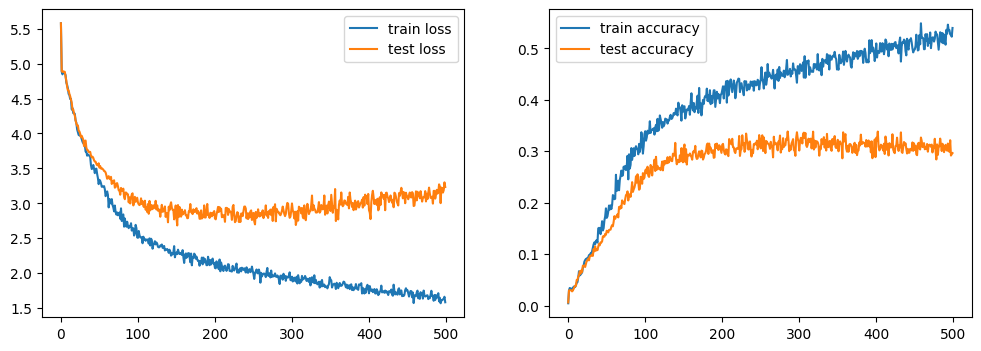

In [53]:
#dataset = CharacterDataset.from_textfile('./input.txt', context_size=256)

model = GPT(context_size=dataset.context_size, vocab_size=dataset.vocab_size, embedding_dim=256)
model.to(DEVICE)
model.train()

train_steps = 10000
batch_size = 32

train_dataset, test_dataset = dataset.train_test_split()

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True),
    batch_size=batch_size,
)
test_dataloader = iter(test_dataloader)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, betas=(0.9, 0.95))
model.train()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for i, (train_x, train_y) in enumerate(tqdm(train_dataloader)):    
    # forward the model
    _,train_loss,train_accuracy = model(train_x.to(DEVICE), train_y.to(DEVICE))

    # save losses on train and test every 20 iterations
    if i % 20 == 0:
        train_losses.append(train_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_x, test_y = next(test_dataloader)
        _,test_loss,test_accuracy = model(test_x.to(DEVICE), test_y.to(DEVICE))
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy.item())

    # backprop and update the parameters
    model.zero_grad(set_to_none=True)
    train_loss.backward()

    # 'trick' to prevent gradients from exploding
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

fig,[ax1, ax2] = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(train_losses, label='train loss')
ax1.plot(test_losses, label='test loss')
ax1.legend()
ax2.plot(train_accuracies, label='train accuracy')
ax2.plot(test_accuracies, label='test accuracy')
ax2.legend()

In [62]:
import types
def generate(self, prompt:str='\n', sample_length: int=256) -> list[int]:
    """Generate sample tokens"""
    device = next(self.parameters()).device
    prompt_tokens = dataset.tokenizer.encode(prompt).ids
    idx = torch.tensor(prompt_tokens, dtype=torch.long, device=device)

    for _ in trange(sample_length, desc='Sampling'):
        logits,_,_ = self(idx[-self.context_size:][None])
        logits = logits[0,-1,:]

        probs = F.softmax(logits, dim=0)

        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, idx_next])

    return idx.tolist()
setattr(model, "generate", types.MethodType(generate, model))

model.eval()
sample = model.generate(prompt='He will ')
print(dataset.tokenizer.decode(sample))

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

He will have deserved the church:
I'll in the indignation of these wretch,
Your princely 'narm' sect, which is pluck'd.

HASTINGS:
My masters quest;
Or I'll my badmost at Pomfret, my gracious,
See how means, I would have spoke your father
Which you shall purge no more neome dity,
For hath still the belly of her state would committed?

RATCLIFF:
Had you not down so boy?

BUCKINGHAM:
Messenger of the commons in
From a man arch-brown
